## Noising attack demo

/share/u/kevin/miniconda3/envs/asdf_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.24it/s]


✅ ESD-X model loaded successfully!


100%|██████████| 50/50 [00:01<00:00, 25.20it/s]


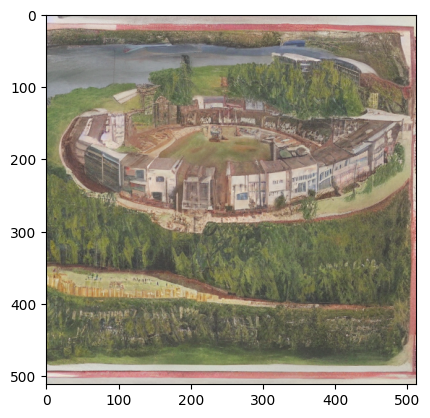

In [1]:
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt

# Check for GPU availability (MPS for Apple Silicon or CUDA for NVIDIA GPUs)
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load the ESD-X model from Hugging Face
model_id = "kevinlu4588/esd-x-airliner"

pipeline = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device != "cpu" else torch.float32,  # Use FP16 for GPU, FP32 for CPU
    use_safetensors=True
).to(device)

print("✅ ESD-X model loaded successfully!")

# Sample text prompt for generation
prompt = "An airliner"

# Inference
with torch.inference_mode():
    image = pipeline(prompt).images[0]

plt.imshow(image)


## Applying the Noising Attack

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from noisy_diffusers.schedulers.eta_ddim_scheduler import DDIMScheduler

pipeline.scheduler = DDIMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

# List of eta and variance scale values
etas = [1.3, 1.5, 1.7, 1.8, 1.9]
variance_scales = [1.0, 1.02, 1.03, 1.035, 1.04]

# Initialize an empty list to store images and labels
images = []
labels = []
pipeline.safety_checker = None

# Total number of combinations
total_combinations = len(etas) * len(variance_scales)

# Iterate through eta values and variance scales to generate images with tqdm
with tqdm(total=total_combinations, desc="Generating Images") as pbar:
    for eta in etas:
        for variance_scale in variance_scales:
            image = pipeline("airliner", eta=eta, variance_scale=variance_scale, seed=1000).images[0]
            images.append(image)
            labels.append(f"eta={eta}\nv_scale={variance_scale}")
            pbar.update(1)

# Calculate grid dimensions
n_cols = len(etas)
n_rows = len(variance_scales)

# Create a grid of subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Plot each image in the grid
for i, img in enumerate(images):
    row = i // n_cols
    col = i % n_cols
    axs[row, col].imshow(img)
    axs[row, col].axis("off")  # Hide axes
    axs[row, col].set_title(labels[i], fontsize=10)  # Add title for each image

plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'noisy_diffusers'

In [19]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

def get_best_image(images, prompt):
    """
    Given a list of images and a prompt, returns the image with the highest CLIP score.

    Args:
        images (list): List of PIL Image objects or paths to image files.
        prompt (str): The text prompt to compare against the images.

    Returns:
        PIL.Image: Image with the highest CLIP score.
    """
    # Load CLIP model and processor
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    model = model.to(device)
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    # Ensure all images are PIL images
    pil_images = [Image.open(img) if isinstance(img, str) else img for img in images]

    # Encode inputs
    inputs = processor(text=[prompt], images=pil_images, return_tensors="pt", padding=True).to(device)

    # Calculate CLIP scores
    with torch.no_grad():
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image

    # Get the best image index
    best_idx = logits_per_image.argmax().item()

    return pil_images[best_idx]


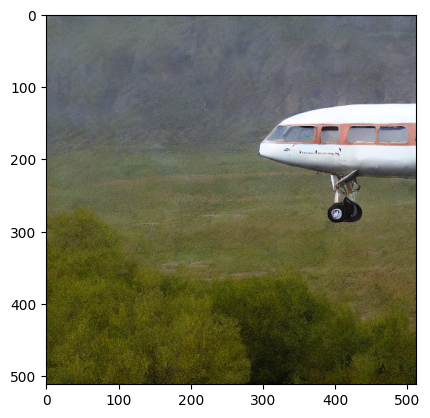

In [20]:
plt.imshow(get_best_image(images, "airliner"))